In [1]:
# Titanic classification: EDA -> preprocess -> LogisticRegression -> save
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import joblib

plt.style.use("seaborn-v0_8")

In [2]:
df = sns.load_dataset('titanic')
df.shape, df.head()

((891, 15),
    survived  pclass     sex   age  sibsp  parch     fare embarked  class  \
 0         0       3    male  22.0      1      0   7.2500        S  Third   
 1         1       1  female  38.0      1      0  71.2833        C  First   
 2         1       3  female  26.0      0      0   7.9250        S  Third   
 3         1       1  female  35.0      1      0  53.1000        S  First   
 4         0       3    male  35.0      0      0   8.0500        S  Third   
 
      who  adult_male deck  embark_town alive  alone  
 0    man        True  NaN  Southampton    no  False  
 1  woman       False    C    Cherbourg   yes  False  
 2  woman       False  NaN  Southampton   yes   True  
 3  woman       False    C  Southampton   yes  False  
 4    man        True  NaN  Southampton    no   True  )

In [3]:
df.info()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   survived     891 non-null    int64   
 1   pclass       891 non-null    int64   
 2   sex          891 non-null    object  
 3   age          714 non-null    float64 
 4   sibsp        891 non-null    int64   
 5   parch        891 non-null    int64   
 6   fare         891 non-null    float64 
 7   embarked     889 non-null    object  
 8   class        891 non-null    category
 9   who          891 non-null    object  
 10  adult_male   891 non-null    bool    
 11  deck         203 non-null    category
 12  embark_town  889 non-null    object  
 13  alive        891 non-null    object  
 14  alone        891 non-null    bool    
dtypes: bool(2), category(2), float64(2), int64(4), object(5)
memory usage: 80.7+ KB


,0
survived,0
pclass,0
sex,0
age,177
sibsp,0
parch,0
fare,0
embarked,2
class,0
who,0


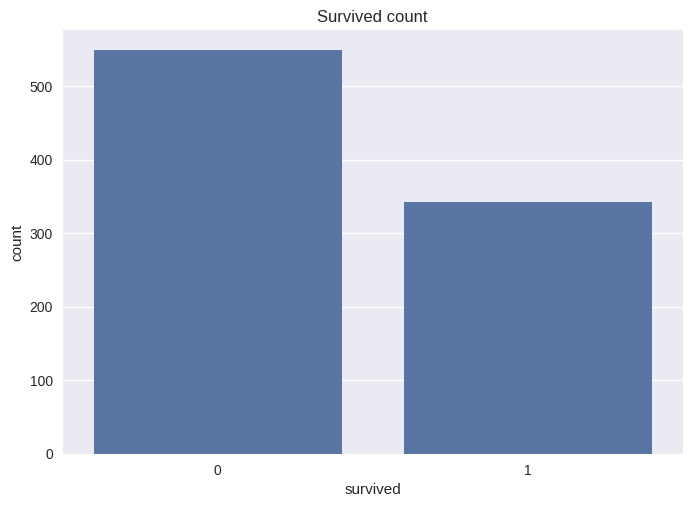

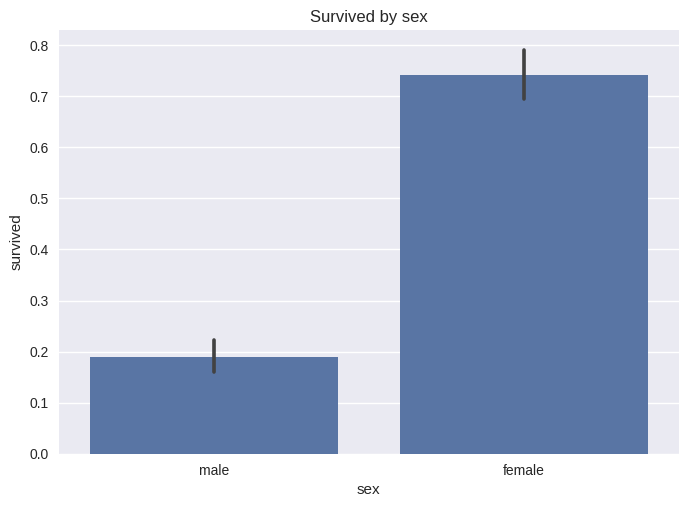

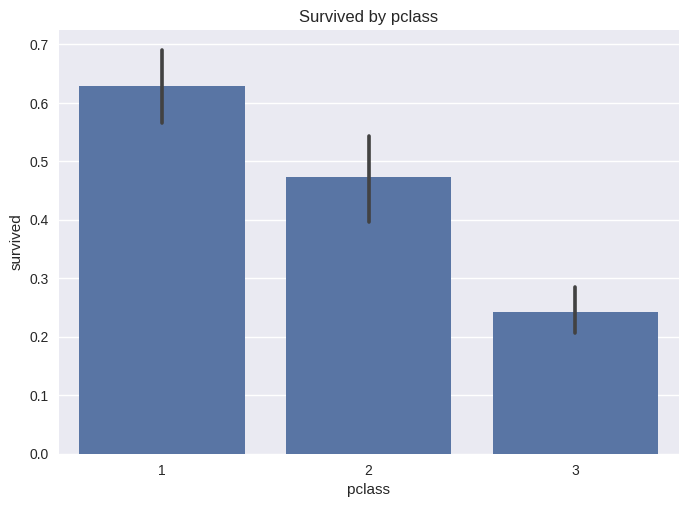

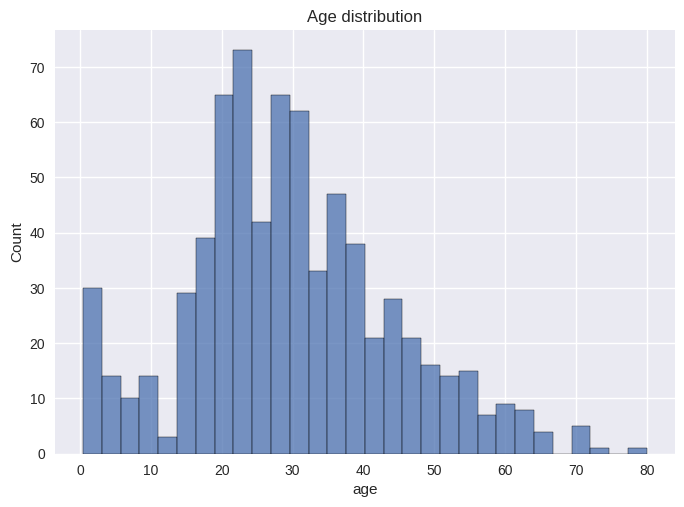

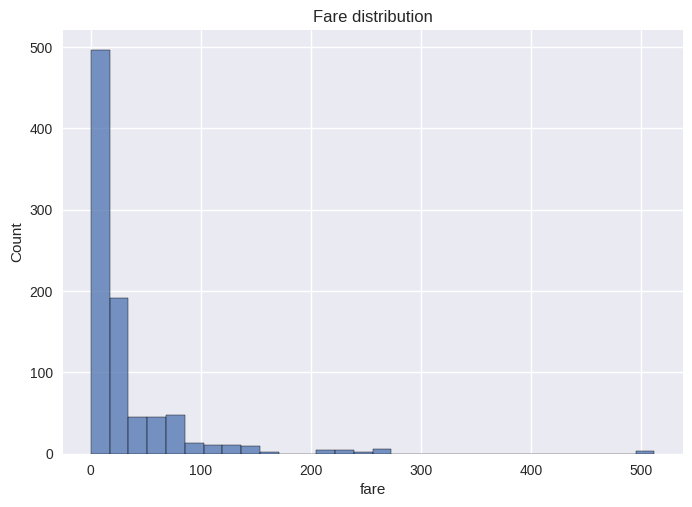

In [4]:
#Simple plots (EDA)

# target distribution
sns.countplot(x = 'survived', data = df)
plt.title('Survived count')
plt.show()

# survival by sex and pclass
sns.barplot(x = 'sex', y = 'survived', data = df)
plt.title('Survived by sex')
plt.show()

sns.barplot(x = 'pclass',  y = 'survived', data = df)
plt.title('Survived by pclass')
plt.show()

# Age distribution
sns.histplot(df['age'].dropna(), bins = 30 )
plt.title('Age distribution')
plt.show()

# Fare distribution
sns.histplot(df['fare'].dropna(), bins = 30)
plt.title('Fare distribution')
plt.show()

In [5]:
#Choose features
features = ['pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'embarked']
target = 'survived'
data  = df[features + [target]].copy()
data.head()

,pclass,sex,age,sibsp,parch,fare,embarked,survived
0,3,male,22.0,1,0,7.2500,S,0
1,1,female,38.0,1,0,71.2833,C,1
2,3,female,26.0,0,0,7.9250,S,1
3,1,female,35.0,1,0,53.1000,S,1
4,3,male,35.0,0,0,8.0500,S,0


In [6]:
#Preprocessing pipeline

numeric_features = ['age','sibsp','parch','fare','pclass']
categorical_features = ['sex','embarked']

numerical_transfomer = Pipeline(steps =[
    ('imputer', SimpleImputer(strategy = 'median')),
    ('scaler', StandardScaler())
])

categorical_transfomer = Pipeline(steps = [
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown = 'ignore'))

])

preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_transfomer, numeric_features),
    ('cat', categorical_transfomer, categorical_features )

])


In [8]:
#Train/test split

x = data[features]
y = data[target]

x_train, x_test, y_train, y_test = train_test_split(x, y ,test_size = 0.20, random_state = 42, stratify = y)

x_train.shape, x_test.shape, y_train.value_counts(normalize = True)

((712, 7),
 (179, 7),
 survived
 0    0.616573
 1    0.383427
 Name: proportion, dtype: float64)

In [10]:
clf = Pipeline(steps = [
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter = 1000, solver = 'lbfgs'))
    ])
clf.fit(x_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'sibsp', 'parch',
                                                   'fare', 'pclass']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['sex', 'embarked'])])),
                ('classifier', LogisticRegression(max_iter=1000))])

In [12]:
#Evaluate on test set

y_predict = clf.predict(x_test)
y_probability = clf.predict_proba(x_test)

print('Accuracy:', accuracy_score(y_test,y_predict))
print('Precision:', precision_score(y_test,y_predict))
print('Recall:', recall_score(y_test,y_predict))
print('F1:', f1_score(y_test, y_predict))
print('\nClassification Report:\n', classification_report(y_test, y_predict))

Accuracy: 0.8044692737430168
Precision: 0.7931034482758621
Recall: 0.6666666666666666
F1: 0.7244094488188977

Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.89      0.85       110
           1       0.79      0.67      0.72        69

    accuracy                           0.80       179
   macro avg       0.80      0.78      0.79       179
weighted avg       0.80      0.80      0.80       179



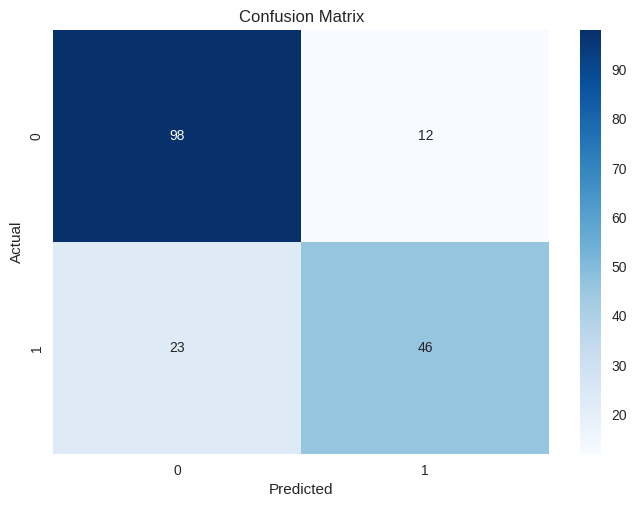

In [14]:
#Confusion matrix plot

import seaborn as sns
import matplotlib.pyplot as plt
cm = confusion_matrix(y_test, y_predict)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted'); plt.ylabel('Actual'); plt.title('Confusion Matrix')
plt.show()

In [16]:
#Cross-validation quick check

cv_scores = cross_val_score(clf, x, y, cv=5, scoring='f1')
print("5-fold CV F1 scores:", cv_scores)
print("Mean F1:", cv_scores.mean())


5-fold CV F1 scores: [0.71428571 0.71641791 0.71532847 0.672      0.75968992]
Mean F1: 0.7155444028734761


In [20]:
os.makedirs('projects/titanic', exist_ok=True)
model_path = 'projects/titanic/titanic_model.joblib'
joblib.dump(clf, model_path)
print("Saved model to:", model_path)

Saved model to: projects/titanic/titanic_model.joblib


In [21]:
# load model and predict
model = joblib.load(model_path)
sample = x_test.iloc[:3]
print("Sample features:\n", sample)
print("Predictions:", model.predict(sample))
print("Probabilities:", model.predict_proba(sample))


Sample features:
      pclass   sex   age  sibsp  parch    fare embarked
565       3  male  24.0      2      0  24.150        S
160       3  male  44.0      0      1  16.100        S
553       3  male  22.0      0      0   7.225        C
Predictions: [0 0 0]
Probabilities: [[0.93202731 0.06797269]
 [0.95235918 0.04764082]
 [0.84475714 0.15524286]]
